<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/PortoSeguro/imbalanced_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Santander - Resampling stratecies for imbalanced datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

불균형한 데이터셋에서의 resmapling 전략.

> [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data)

# 목차
1. Imbalanced datasets
2. The metrics trap
3. Confutsion matrix
4. Resampling
5. Random under-sampling
6. Random over-sampling
7. Python imbalanced-learn module
8. Random under-sampling and over-sampling with imbalaced-learn
9. Under-sampling : Tomek links
10. Under-samplinf : Cluster Centroids
11. Over-sampling : SMOTE
12. Over-sampling followed by under-sampling
13. Recommended reading

# 1.Imbalanced datasets
---
이 커널에서 우리는 리샘플링에 중점을 두고 불균형한 데이터를 다루는 몇 가지 기술을 알 수 있다. 이 커널에서 사용되는 Porto Seguro의 안전 운전자 예측 대회는 불균형 클래스의 고전적인 문제이다. 모든 고객을 고려할 때 보험 청구가 비정상적인 경우로 간주될 수 있기 때문이다. 불균형 클래스의 다른 고전적인 예는 금융 사기 및 컴퓨터 네트워크에 대한 공격의 탐지이다.   

 이제 불균형한 데이터를 확인해보자.

Class 0 : 573518
class 1 : 21694
Proportion : 26.44, :1


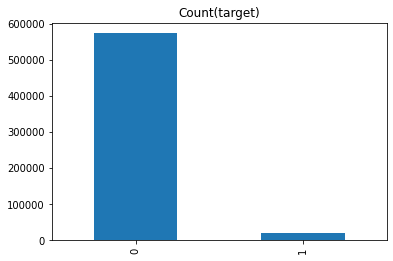

In [6]:
import os
os.chdir('/content/drive/MyDrive/kaggle/PortoSeguro')

import numpy as np
import pandas as pd

df_train = pd.read_csv('train.csv')

target_count = df_train.target.value_counts()
print(f"Class 0 : {target_count[0]}")
print(f"class 1 : {target_count[1]}")
print(f"Proportion : {round(target_count[0] / target_count[1],2)}, :1")

target_count.plot(kind='bar', title='Count(target)')

# 2.The metric trap
---
초보자가 불균형 데이터 세트를 다룰 때 발생하는 주요 문제 중 하나는 모델을 평가하는데 사용되는 메트릭과 관련이 있다. accuracy_score와 같은 간단한 메트릭을 사용하는 것은 오해를 유발할 수 있다. 불균형 클래스가 매우 높은 데이터 집합에서 분류자가 피처 분석을 수행하지 않고 항상 가장 일반적인 클래스를 "예측"한다면 여전히 높은 정확도와 명백한 환상을 가질 것이다.  

**이 실험은 Feature Engineering 없이 간단한 교차 검증을 사용해 수행한다.**

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 'id'와 'target'열 제거
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test , y_pred)
print(f"Accuracy {accuracy * 100.0 : .2f}")

Accuracy  96.36


위와 같은 코드에서 한가지 변수만 사용해 예측(이는 분류기의 정확도를 크게 저하시킬 것이다.)

In [11]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy {accuracy*100.0:.2f}")

Accuracy 96.36


보다시피 높은 정확도는 환상에 불과했다. 이처럼 불균형 데이터 세트에 사용되는 메트릭을 선택하는 것은 매우 중요하다.  
이 대회에서 평가 지표는 **정규화된 지니 계수**이며, 이는 불균형 데이터 세트에 대한 보단 강력한 지표로, 무작위 추측의 경우 약 0에서 만점의 경우 0.5에 이른다.

# 3.Confusion Matrix
---
결과를 평가하는 흥미로운 방법은 각 클래스에 대한 정확한 예측과 잘못된 예측을 보여주는 <u>**혼동 행렬(Confusion Matrix)**</u>을 사용하는 것 이다.   
1행 1열은 정확하게 예측된 클래스 수를 나타내고 1행 2열은 1로 예측된 클래스 수를 나타낸다.  
두번째 행에서 모든 1 클래스 항목이 0으로 잘못 예측되었다.  

따라서 혼동 행렬의 대각선 값이 높을수록 더 좋으며, 정확한 에측을 나타낸다.

Confustion matrix :
 [[114709      0]
 [  4334      0]]


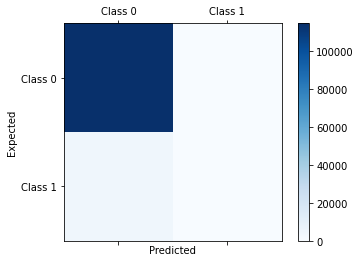

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(f"Confustion matrix :\n {conf_mat}")

labels = ['Class 0','Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap = plt.cm.Blues)

fig.colorbar(cax)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# 4.Resampling
크게 불균형한 데이터 세트를 처리하기 위해 일반적으로 사용되는 기술을 리샘플링이라 하며  
 이는 다수 클래스(under-sampling)에서 샘플을 제거하고 소수 클래스(over-sampling)에서 더 많은 예제를 추가하는 것으로 구성된다.

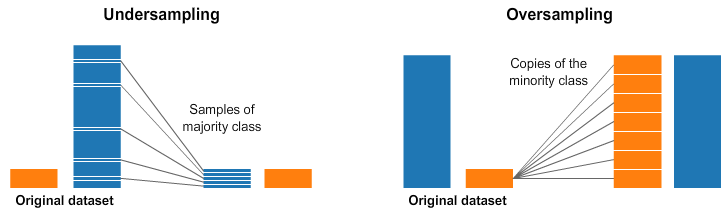

resampling은 클래스 균형을 맞추는 장점에도 불구하고 이 기술들은 약점이 있다. 오버샘플링(over-sampling)의 가장 간단한 구현은 소수 클래스로부터 무작위 레코드를 복제하는 것인데, 이는 과적합을 유발할 수 있다. 언더샘플링(under-sampling)에서 가장 간단한 기술은 다수의 클래스에서 무작위 레코드를 제거하는 것으로, 정보의 손실을 야기할 수 있다. 

**아래에서는 DataFrame.sample 방법을 사용해 각 클래스를 랜덤하게 샘플로 가져오는 기본 예를 구현해본다.**

In [25]:
# class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target']==0]
df_class_1 = df_train[df_train['target']==1]

# 5.Random under-sampling

Random under-sampling : 
1    21694
0    21694
Name: target, dtype: int64


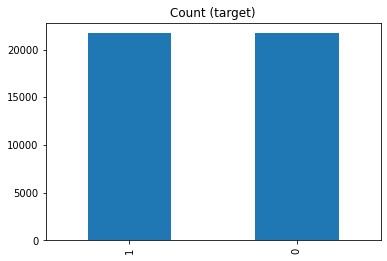

In [54]:
df_class_0_under = df_class_0.sample(count_class_1) # class가 1인 행의 갯수만큼 무작위 추출
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)  # target 변수 갯수 맞춤

print('Random under-sampling : ')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)')

# 6.Random over-sampling

Random over-sampling : 
1    573518
0    573518
Name: target, dtype: int64


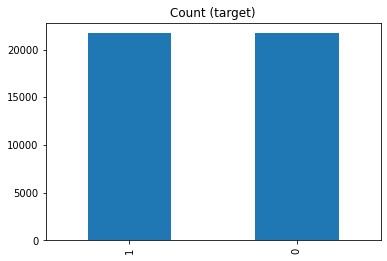

In [56]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling : ')
print(df_test_over.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)')

# 7.Python imbalanced-learn module
---
과학 문헌에는 보다 정교한 리샘플링 기술이 제단되어 있다.  

예를 들면 우리는 다수의 클래스 레코드를 군집화할 수 있고, 각 군집에서 레코드를 제거해 언더샘플링을 수행해 정보를 보존할 수 있다.  
오버샘플링에서는 소수 클래스 레코드의 정확한 복사본을 만드는 대신 이러한 복사본에 작은 변화를 도입해 보다 다양한 합성 샘플을 만들 수 있다.  

Python 라이브러리 inbalance-learn을 사용해 리샘플링 기술을 일부  적용하겠다. scikit-learn과 호환되며 scikit-learn-contrib 프로젝트의 일부이다.

In [57]:
import imblearn

시각화를 쉽게하기 위해 make_classification 방법을 사용해 작은 불균형 샘플 데이터 세트를 생성해보겠다.

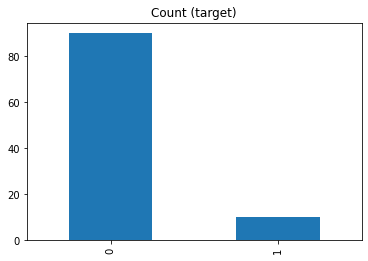

In [62]:
from sklearn.datasets import make_classification

X,y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9,0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y

df.target.value_counts().plot(kind='bar', title='Count (target)')

또한 2차원 플롯 함수인 **plot_2d_space**를 만들어 데이터 분포를 확인해본다. 

In [83]:
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
        
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

데이터 집합은 많은 차원(features)을 가지고 있고 그래프는 2D이기 때문에 PCA(주성분 분석)을 사용해 데이터 집합의 크기를 줄일 것이다. 

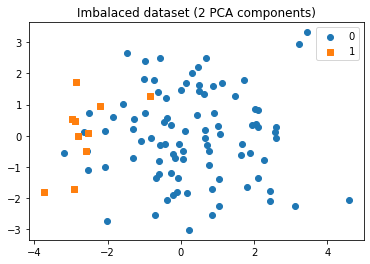

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalaced dataset (2 PCA components)')

# 8.Random under-sampling and over-sampling with imbalanced-learn
---

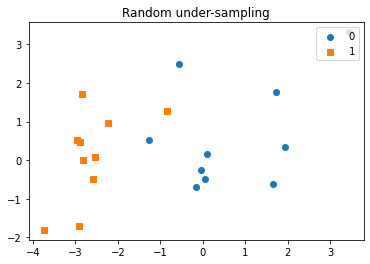

In [129]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=1234)
X_rus, y_rus = rus.fit_resample(X,y)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new ramdom picked points


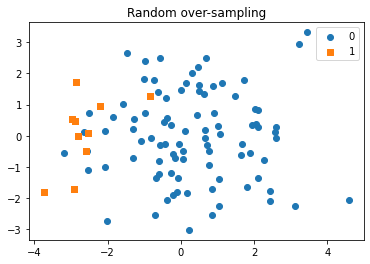

In [118]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new ramdom picked points')
plot_2d_space(X_ros, y_ros, 'Random over-sampling')

# 9.Under-smapling :  Tomek links
---
Tomek 링크는 매우 가까운 인스턴스 쌍이지만 서로 반대되는 클래스이다.   
각 쌍의 다수 클래스 인스턴스를 제거하면 두 클래스 사이의 공간이 늘어나 분류 프로세스가 용이해진다. 

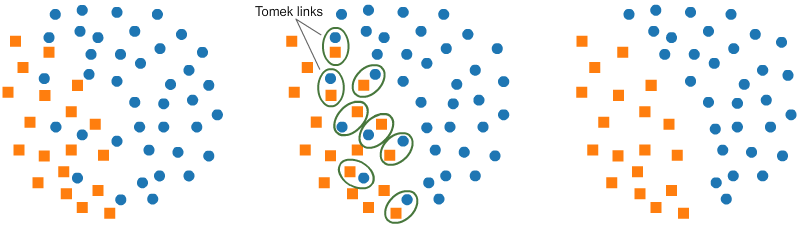

아래 코드에서 ratio='majority'를 사용해 대다수 클래스를 다시 샘플링한다. 

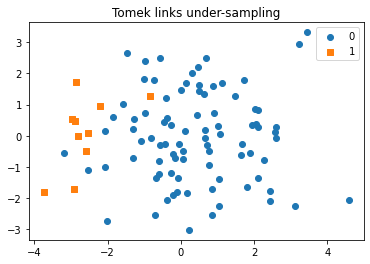

In [128]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

# 10.Under-sampling : Cluster Centroids
---
이 기법은 클러스터링 방법을 기반으로 중심을 생성해 언더샘플링을 수행한다. 정보를 보존하기 위해 데이터느 이전에 유사성을 기준으로 그룹화된다.   

이 예에서는 매개 변수 비율에 대해 {0:10} dict를 전달해 다수 클래스(0)와 모든 소수 클래스(1)의 10개 요소를 보존한다. 

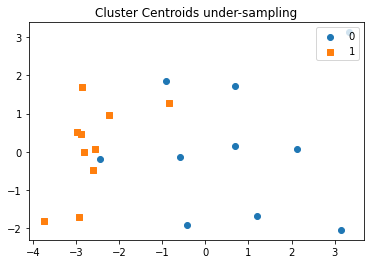

In [135]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy='majority')
x_cc, y_cc = cc.fit_resample(X,y)

plot_2d_space(x_cc, y_cc, 'Cluster Centroids under-sampling')

# 11.Over-sampling : SMOTE
SMOTE(Synthetic Minority Oversampling TEchnique는 이미 존재한는 것들을기반으로 소수 계층을 위한 합성 요소로 구성된다. 소수 클래스의 점을 무작위로 피싱하고 이 점에 대해 k-nn을 계산한다. 합성 점이 선택한 점과 인접 점 사이에 추가된다. 

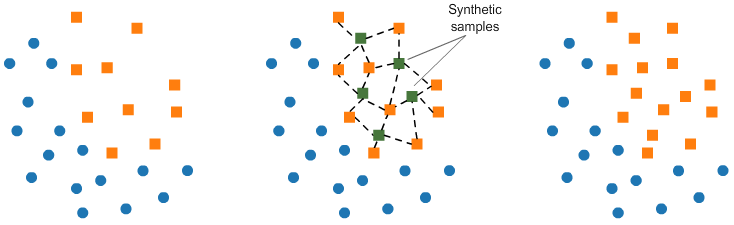

소수 클래스를 다시 샘플링하기 위해 sampling_strategy='minority'를 사용한다.

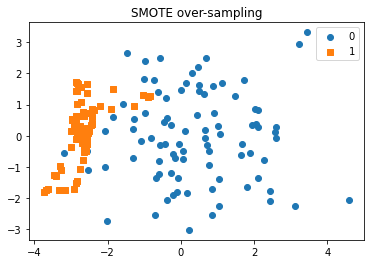

In [137]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(x_sm, y_sm, 'SMOTE over-sampling')

# 12.Over-sampling followed by under-sampling
---
이제 SMOTE 및 Tomek links 기술을 사용해 오버샘플링과 언더샘플링을 조합해본다.

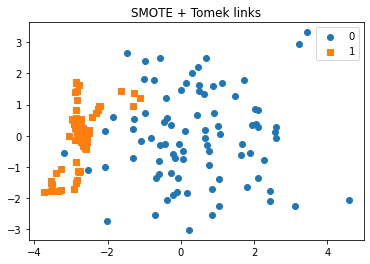

In [139]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')
x_smt, y_smt = smt.fit_resample(X,y)

plot_2d_space(x_smt, y_smt, 'SMOTE + Tomek links')

#13.Reference
---
The imbalanced-learn documentation:  
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

The imbalanced-learn GitHub:  
https://github.com/scikit-learn-contrib/imbalanced-learn

Comparison of the combination of over- and under-sampling algorithms:  
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html

Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002):  
https://www.jair.org/media/953/live-953-2037-jair.pdf